# CIFAR-10 Classification with an LDA Head
This notebook trains a lightweight convolutional encoder with an LDA head on CIFAR-10, alongside a softmax baseline, then visualises the learned embedding spaces side by side.

### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from src.lda import TrainableLDAHead, DNLLLoss

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

device = cuda


### Data


In [3]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)
pin_memory = torch.cuda.is_available()

train_tfm = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR10(root='./data', train=True, transform=train_tfm, download=True)
test_ds  = datasets.CIFAR10(root='./data', train=False, transform=test_tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4, pin_memory=pin_memory)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=4, pin_memory=pin_memory)
len(train_ds), len(test_ds)


(50000, 10000)

### Model: encoder + heads (LDA + softmax)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class DeepLDA(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = TrainableLDAHead(C, D)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)

class SoftmaxHead(nn.Module):
    def __init__(self, D, C):
        super().__init__()
        self.linear = nn.Linear(D, C)

    def forward(self, z):
        return self.linear(z)

class DeepClassifier(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = SoftmaxHead(D, C)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)


### Train & Eval


In [ ]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

lda_model = DeepLDA(C=10, D=9).to(device)
lda_opt = torch.optim.Adam(lda_model.parameters())
lda_loss_fn = DNLLLoss(lambda_reg=.01)

lda_train_acc = []
lda_test_acc = []

for epoch in range(1, 101):
    lda_model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        logits = lda_model(x)
        loss = lda_loss_fn(logits, y)
        lda_opt.zero_grad(set_to_none=True)
        loss.backward()
        lda_opt.step()
        with torch.no_grad():
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(lda_model, test_ld)
    lda_train_acc.append(tr_acc)
    lda_test_acc.append(te_acc)
    print(f"[LDA {epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}")


[01] train loss=6.7806 acc=0.3739 | test acc=0.4696
[02] train loss=4.6383 acc=0.5797 | test acc=0.5817
[03] train loss=3.0360 acc=0.6640 | test acc=0.6403
[04] train loss=1.5858 acc=0.7091 | test acc=0.6670
[05] train loss=0.2085 acc=0.7375 | test acc=0.7052
[06] train loss=-1.0531 acc=0.7538 | test acc=0.7323
[07] train loss=-2.0727 acc=0.7758 | test acc=0.7477
[08] train loss=-2.6346 acc=0.7949 | test acc=0.7781
[09] train loss=-2.9022 acc=0.8198 | test acc=0.7926
[10] train loss=-3.0299 acc=0.8425 | test acc=0.7949
[11] train loss=-3.1037 acc=0.8576 | test acc=0.8070
[12] train loss=-3.1488 acc=0.8698 | test acc=0.8127
[13] train loss=-3.1807 acc=0.8775 | test acc=0.8386
[14] train loss=-3.2111 acc=0.8867 | test acc=0.8551
[15] train loss=-3.2298 acc=0.8920 | test acc=0.8468
[16] train loss=-3.2399 acc=0.8965 | test acc=0.8251
[17] train loss=-3.2528 acc=0.9010 | test acc=0.8257
[18] train loss=-3.2679 acc=0.9060 | test acc=0.8361
[19] train loss=-3.2819 acc=0.9104 | test acc=0.842

### Softmax head baseline
Train a second model with the same encoder but a standard softmax classifier for a side-by-side comparison.

In [ ]:
softmax_model = DeepClassifier(C=10, D=9).to(device)
softmax_opt = torch.optim.Adam(softmax_model.parameters())
softmax_loss_fn = nn.CrossEntropyLoss()

softmax_train_acc = []
softmax_test_acc = []

for epoch in range(1, 101):
    softmax_model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        logits = softmax_model(x)
        loss = softmax_loss_fn(logits, y)
        softmax_opt.zero_grad(set_to_none=True)
        loss.backward()
        softmax_opt.step()
        with torch.no_grad():
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(softmax_model, test_ld)
    softmax_train_acc.append(tr_acc)
    softmax_test_acc.append(te_acc)
    print(f"[Softmax {epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}")


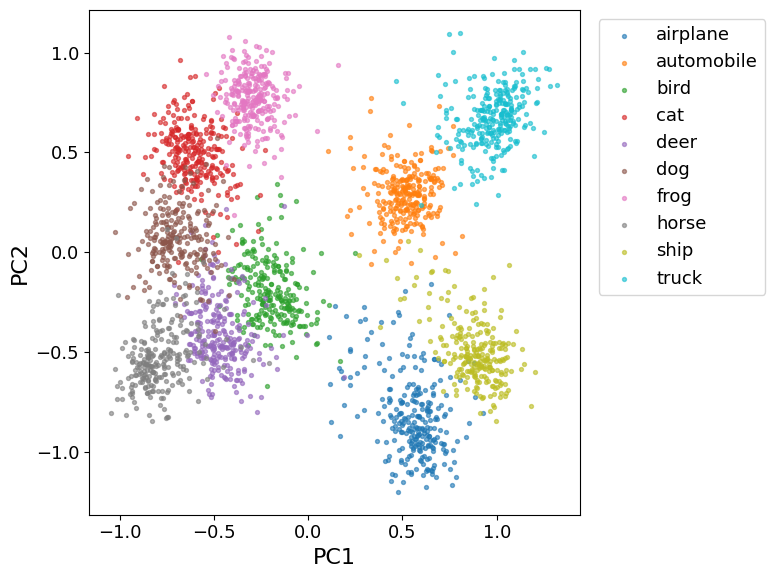

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def collect_embeddings(model, loader, batches=10):
    model.eval()
    embeds, labels = [], []
    for i, (x, y) in enumerate(loader):   # use train_ld if you prefer
        x = x.to(device)
        z = model.encoder(x).cpu()
        embeds.append(z)
        labels.append(y)
        if i >= batches - 1:   # 10 batches ≈10k points; raise/lower to taste
            break

    z = torch.cat(embeds)
    y = torch.cat(labels)

    # 2D projection (PCA)
    z0 = z - z.mean(0, keepdim=True)
    _, _, V = torch.pca_lowrank(z0, q=2)
    z2 = z0 @ V[:, :2]
    return z2, y

lda_z2, lda_y = collect_embeddings(lda_model, train_ld)
softmax_z2, softmax_y = collect_embeddings(softmax_model, train_ld)

plt.rcParams.update({
    "font.size": 14, "axes.labelsize": 16, "legend.fontsize": 13,
    "xtick.labelsize": 13, "ytick.labelsize": 13
})

palette = plt.cm.tab10.colors
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plots = [
    (axes[0], lda_z2, lda_y, "Deep LDA embeddings"),
    (axes[1], softmax_z2, softmax_y, "Softmax head embeddings"),
]

for ax, z2, y, title in plots:
    for c in range(10):
        idx = y == c
        ax.scatter(z2[idx, 0], z2[idx, 1], s=8, alpha=0.6, color=palette[c], label=train_ds.classes[c])
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(title)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.02), loc="lower center", ncol=5)
plt.tight_layout(rect=(0, 0.07, 1, 1))
plt.savefig('plots/cifar10_lda_vs_softmax_embeddings.png', dpi=600)
